### Your name:

<pre> Derek Pyne </pre>

### Collaborators:

<pre> None </pre>


In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Classification - Based on Week 3

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In week 3, you:
- Explored the dataset
- Built a full data pipeline
- Pre-processed data, explored features

Building on your work of week 3:
- Split dataset into 3 sets:
  - 70% -> Training and cross validation
  - 15% -> Model Stacking
  - 15% -> Testing
  

- Tune a decision tree classfier:
  - select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice 
  - tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    - criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None    
  - tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.
  

## Obtain

In [2]:
df = pd.read_excel("datasets/credit/default_of_credit_card_clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)
df.drop('ID', axis=1, inplace=True)

In [3]:
from sklearn.model_selection import train_test_split

df_labels = df['default payment next month'].copy()
df.drop('default payment next month', axis=1, inplace=True)

X_train, X_temp, y_train, y_temp = train_test_split(df, df_labels, 
                                    test_size=0.3, random_state=123)
X_ms, X_test, y_ms, y_test = train_test_split(X_temp, y_temp, 
                                    test_size=0.5, random_state=123)

In [4]:
pd.Series({'Train Size': len(X_train), 
           'Model Stacking Size': len(X_ms),
           'Test Size': len(X_test)})

Model Stacking Size     4500
Test Size               4500
Train Size             21000
dtype: int64

## Extract

We can now build out a pipeline by one-hot encoding our categorical features and scaling our numerical features.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# exclusion_attribs = ['PAY_0', 'PAY_1', 'PAY_2', 'PAY_3', 
#                      'PAY_4', 'PAY_5', 'PAY_6']
exclusion_attribs = []
cat_attribs = ['EDUCATION', 'MARRIAGE', 'SEX']
num_attribs = [c for c in df.columns 
               if c not in cat_attribs and c not in exclusion_attribs]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder())
    ])

We can now transform all three of our datasets.

In [7]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
full_pipeline.fit(X_train)
X_train_prepared = full_pipeline.transform(X_train)
X_ms_prepared = full_pipeline.transform(X_ms)
X_test_prepared = full_pipeline.transform(X_test)

/home/derek_pyne/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/derek_pyne/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Model

We will start by training a decision tree classifier. To get a sense of the model performance we tune each parameter on its own before performing a larger **Randomized CV Search** on the region that looks promising.

Since this model is imbalanced, we'll use the **f1** score to judge the performance.

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import reciprocal, uniform, expon, randint

def parameter_tuner(X, y, model, param_grid, plot=True, scoring='f1', cv=4, n_iter=50):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=8, verbose=1)
    grid_search.fit(X, y)
    cvres = grid_search.cv_results_
    
    param_grid_dict_list = dict(zip(cvres["params"][0], zip(*[d.values() for d in cvres["params"]])))
    result_df = pd.DataFrame({**{'score': cvres["mean_test_score"]}, **param_grid_dict_list})

    if plot:
        for d in param_grid_dict_list:
            result_df.plot(x=d, y='score', legend=False)
            plt.ylabel('score')
    return result_df, grid_search.best_estimator_

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Done   5 out of  20 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.9s finished


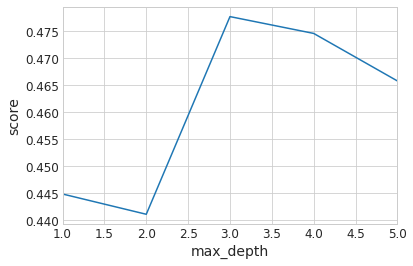

In [9]:
from sklearn.tree import DecisionTreeClassifier
result_df = parameter_tuner(X_train_prepared, y_train, DecisionTreeClassifier(), 
                {'max_depth': [1, 2, 3, 4, 5]})

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    3.0s finished


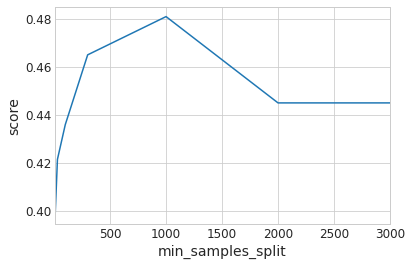

In [10]:
result_df = parameter_tuner(X_train_prepared, y_train, DecisionTreeClassifier(), 
                {'min_samples_split': [10, 30, 100, 300, 1000, 2000, 3000]})

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    3.0s finished


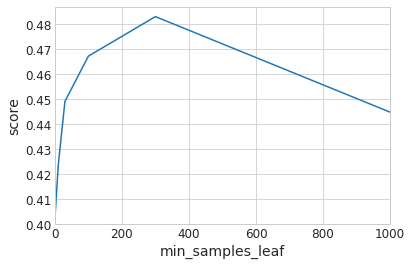

In [11]:
result_df = parameter_tuner(X_train_prepared, y_train, DecisionTreeClassifier(), 
                {'min_samples_leaf': [1, 10, 30, 100, 300, 1000]})

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Done   9 out of  24 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    1.5s finished


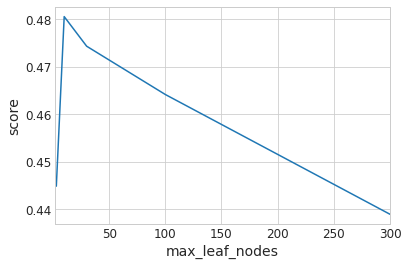

In [12]:
result_df = parameter_tuner(X_train_prepared, y_train, DecisionTreeClassifier(), 
                {'max_leaf_nodes': [2, 3, 10, 30, 100, 300]})

The `criterion` has almost no affect on the result and is something we can leave out of our search.

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


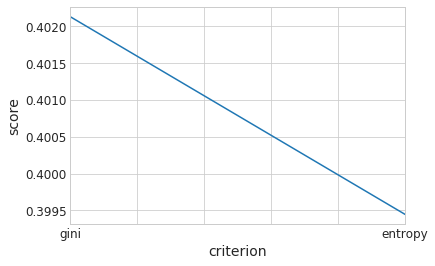

In [13]:
result_df = parameter_tuner(X_train_prepared, y_train, DecisionTreeClassifier(), 
                {'criterion': ['gini', 'entropy']})

In [14]:
from sklearn.metrics import f1_score

def random_search_tuner(clf, params, cv=3, scoring=None, n_iter=500):
    if not scoring:
        scoring = ('f1', f1_score)
        
    random_search = RandomizedSearchCV(clf, params, cv=cv, scoring=scoring[0], 
                                       n_jobs=8, verbose=1, n_iter=n_iter)
    random_search.fit(X_train_prepared, y_train)
    print("Best params: %s" % random_search.best_params_)
    print("Train score: %s" % random_search.best_score_)
    
    y_test_pred = random_search.best_estimator_.predict(X_test_prepared)
    print("Test score: %s" % scoring[1](y_test, y_test_pred))
    return random_search.best_estimator_

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform, expon, randint
params = {'max_depth': randint(2, 5),
        'min_samples_leaf': randint(200, 500),
        'min_samples_split': randint(400, 1500),
        'max_leaf_nodes': randint(2, 40)}

random_search_tuner(DecisionTreeClassifier(), params)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   26.0s
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:   31.7s finished


Best params: {'max_depth': 3, 'max_leaf_nodes': 27, 'min_samples_leaf': 303, 'min_samples_split': 403}
Train score: 0.48613052341
Test score: 0.471502590674


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=27,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=303, min_samples_split=403,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Our model has a high score on both training and test sets showing a good fit to the data.

### Ensemble Learning

Make sure to read and understand the documentation for each classifier.

Remember to make your code modular; it will save you rewriting the same things multiple times and will help avoid copy paste errors.


  
- Tune the following classifiers:
  - Random forest classfier
  - Adaboost Tree classifier
  - Extra trees classifier
  - Gradient Boosted Tree classifier
  - Logistic Regression
  
- Analyze, compare, and interpret your results
- What ensemble yields the best result? Can you identify certain types of events that are classified better/worse from the type of algorithm?
- Is the feature importance consistent for all classifiers?

In [16]:
from sklearn.ensemble import RandomForestClassifier

params = {'min_samples_leaf': randint(200, 500),
          'min_samples_split': randint(50, 1500),
          'max_leaf_nodes': randint(2, 40),
          'n_estimators': randint(3, 100)}

rf_clf = random_search_tuner(RandomForestClassifier(), params, n_iter=50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/derek_pyne/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/derek_pyne/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   26.1s finished


Best params: {'max_leaf_nodes': 22, 'min_samples_leaf': 200, 'min_samples_split': 1049, 'n_estimators': 76}
Train score: 0.385998510332
Test score: 0.34379671151


In [17]:
from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators': randint(25, 100),
          'learning_rate': uniform(.2, 1.0)}

ada_clf = random_search_tuner(AdaBoostClassifier(), params, n_iter=15)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:   16.8s finished


Best params: {'learning_rate': 0.66666696348151122, 'n_estimators': 36}
Train score: 0.463384801135
Test score: 0.449799196787


In [18]:
from sklearn.ensemble import ExtraTreesClassifier

params = {'n_estimators': randint(5, 40)}
etree_clf = random_search_tuner(ExtraTreesClassifier(), params, n_iter=15)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:   44.2s finished


Best params: {'n_estimators': 33}
Train score: 0.458034745032
Test score: 0.442379182156


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': randint(50, 200),
          'learning_rate': uniform(.2, 1.0)}
gb_clf = random_search_tuner(GradientBoostingClassifier(), params, n_iter=15)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  1.1min finished


Best params: {'learning_rate': 0.31720495616144923, 'n_estimators': 180}
Train score: 0.468018856184
Test score: 0.464906632325


In [20]:
from sklearn.linear_model import LogisticRegression

params = {'C': uniform(.5, 5)}
lr_clf = random_search_tuner(LogisticRegression(), params, n_iter=15)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:    1.3s finished


Best params: {'C': 2.3630292080721804}
Train score: 0.367406937031
Test score: 0.347760060744


We can compare feature importances across our classifiers. Right away we see that all of our classifiers, except for the `Random Forest`, have relatively similar importances. Our `Random Forest` classifier performed relatively poorly so this might be a sign that it is overfitted these particular features.

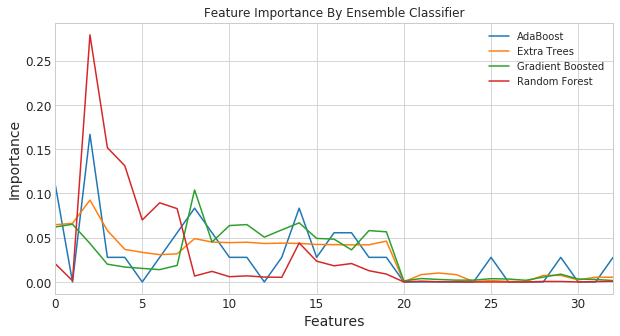

In [21]:
clfs = [('Random Forest', rf_clf), 
        ('AdaBoost', ada_clf), 
        ('Extra Trees', etree_clf), 
        ('Gradient Boosted', gb_clf)]

pd.DataFrame({c[0]: c[1].feature_importances_ for c in clfs}).plot(figsize=(10, 5))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance By Ensemble Classifier')
plt.show()

- Stack your models.
 - Combine the models from the previous section using the stacking approach:
   - Choose the model use to combine. Examples are:
     - Linear Regression
     - Logistic Regression

We can now stack our models and use a **Logistic Regression** classifier as our metaclassifier. We will tune the regularization parameter of this classifier.

In [22]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

ensemble_clfs = [rf_clf, ada_clf, etree_clf, gb_clf, lr_clf]

train_score = []
test_score = []
params = [.0005, .0006, .0007, .0008, .001, .005, .01, .03]

for C in params:
    sclf = StackingClassifier(classifiers=ensemble_clfs, 
                          meta_classifier=LogisticRegression(C=C), 
                          use_probas=False)

    sclf.fit(X_ms_prepared, y_ms)

    y_ms_pred = sclf.predict(X_ms_prepared)
    train_score.append(f1_score(y_ms, y_ms_pred))
    
    y_test_pred = sclf.predict(X_test_prepared)
    test_score.append(f1_score(y_test, y_test_pred))

In [23]:
stacking_df = pd.DataFrame({'train_score': train_score, 'test_score': test_score}, index=params)
stacking_df

,test_score,train_score
0.0005,0.317111,0.492595
0.0006,0.328660,0.492595
0.0007,0.352941,0.834237
0.0008,0.370536,0.834237
0.0010,0.360211,0.834237
0.0050,0.409272,0.999483
0.0100,0.402926,0.999483
0.0300,0.410223,0.999483


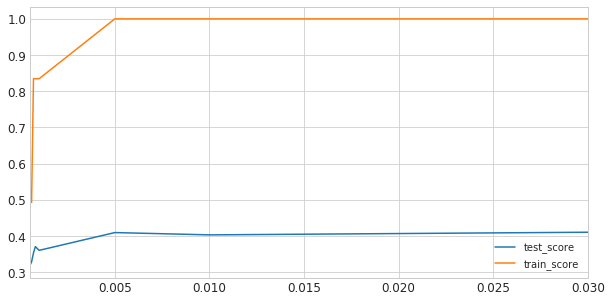

In [24]:
stacking_df.plot(figsize=(10,5))

Here we actually see that our stacking classifier is very hard to control. There is a huge gap between our testing and training scores signifying a model that is strongly overfitting. However, there is very large variation when tuning the regularization parameter making this model not a strong model yet.

Q. (Optional) If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?

`Yes. If our model is overfitting the training set we want to reduce the variance of the model. Decreasing the max_depth reduces the variance of a Decision Tree`

Q. (Optional) If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

`Decision Trees do not require scaled input features so this will have no affect. If the model is underfitting the variance/capability of the model needs to be increased.`

Q. (Optional) What is the difference between hard and soft voting classifiers?

`Hard voting classifiers take the predicted labels from the voting classifiers and simply return the label that receive the most votes. There is no consideration for the probabilites for each label returned by the voting classifiers. Soft voting uses the predicted class probabilities from each classifer and averages these to produce an average predicted probability for each label and makes a final prediction based on this.`

Q. (Optional) If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?

`If our AdaBoost ensemble is underfitting we want to increase the variance of the model. In this case that means allowing the algorithm to pay more attention to the misclassified samples in each step as it builds its estimator chain.  This means increasing the learning_rate and increasing the maximum number of estimators allowed.`

Q. (Optional) If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

`If our Gradient Boosting ensemble is overfitting the training set we should decrease the learning rate to shrink the contribution of additive trees.`

### Conclusions


`We were able to tune a strong Decision Tree classifier and several similarily performing ensemble classifiers. Our stacking classifier strongly overfit the data pushing us to come up with a new strategy here. We might need to increase the proportion of the data that we save for training the stacking classifier but need to measure the affect that this has on our base classifier scores. `

`Overall, we see the power behind ensemble classifiers but also the extra difficulty the pose in tuning, interpreting, and generalizing`

### Submit your notebook

Submit your solution here
https://goo.gl/forms/VKD7Zwu54oHjutDc2
Make sure you rename your notebook to    
W3_UTORid.ipynb    
Example W3_adfasd01.ipynb
